KNN Classifier Model

Fitting 5 folds for each of 112 candidates, totalling 560 fits
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best balanced accuracy: 0.9143

Model saved to /Users/mariaprosgaznares/Desktop/Birdify/models/KNN_model.pkl
Scaler saved to /Users/mariaprosgaznares/Desktop/Birdify/models/KNN_scaler.pkl

Evaluating KNN Model:

Evaluation Metrics Summary:
Accuracy: 0.9487
Balanced Accuracy: 0.9487
Matthews Correlation: 0.9477
Cohen's Kappa: 0.9476
AUC (OvR): 0.9867
AUC (OvO): 0.9867
Weighted Avg F1: 0.9474
Macro Avg F1: 0.9474

Detailed Classification Report:
                            precision    recall  f1-score   support

               Andean Guan       0.96      0.87      0.91        30
          Band-tailed Guan       0.85      0.77      0.81        30
            Barred Tinamou       0.97      1.00      0.98        30
        Bartlett's Tinamou       0.93      0.93      0.93        30
                Baudo Guan       0.97      1.00      0.98        30
             

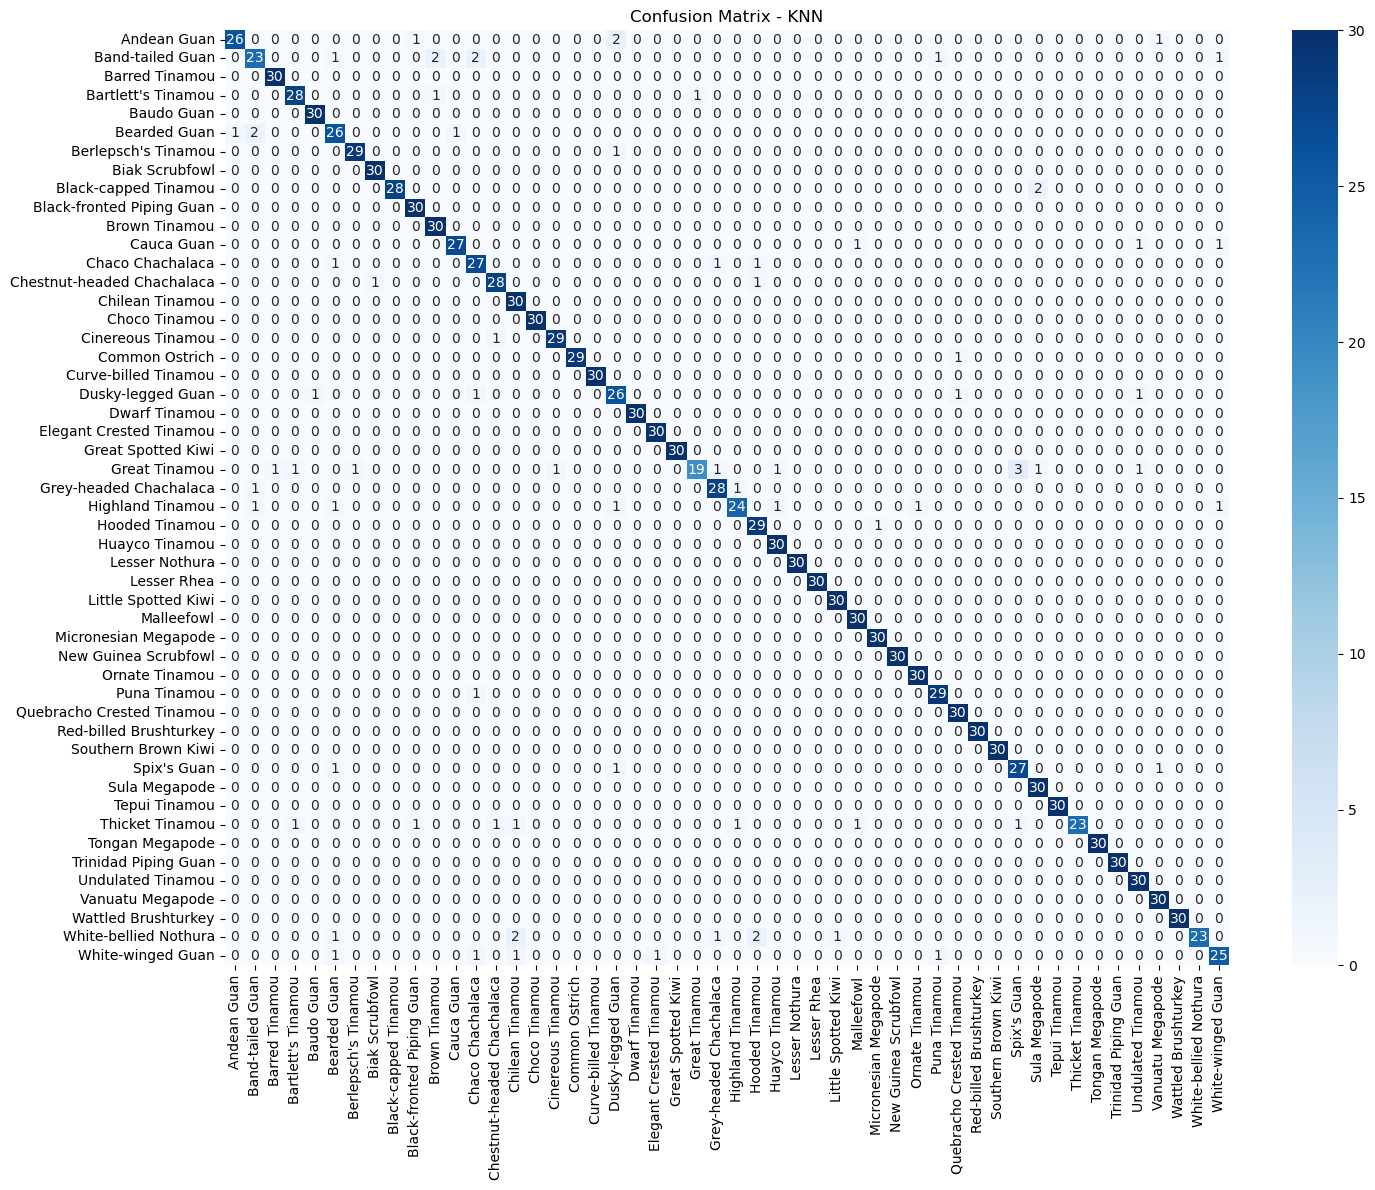


Train accuracy: 1.0000
Test accuracy: 0.9487
Train balanced accuracy: 1.0000
Test balanced accuracy: 0.9487


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                            precision_recall_fscore_support, accuracy_score,
                            balanced_accuracy_score, matthews_corrcoef,
                            cohen_kappa_score)
from pathlib import Path
import json
import joblib

# Configuration
BASE_DIR = Path.cwd() if 'notebooks' not in str(Path.cwd()) else Path.cwd().parent
DATA_DIR = BASE_DIR / 'data'
FEATURES_DIR = DATA_DIR / 'features/selected_feature_TOP50/selected_features.csv'
MODEL_DIR = BASE_DIR / 'models'
METRICS_DIR = BASE_DIR / 'metrics'
RANDOM_STATE = 42

# Create directories if they don't exist
MODEL_DIR.mkdir(parents=True, exist_ok=True)
METRICS_DIR.mkdir(parents=True, exist_ok=True)

def evaluate_model_knn(model, X_test, y_test, label_encoder):
    """Enhanced evaluation function with comprehensive metrics for KNN"""
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Convert to one-hot for multiclass metrics
    y_onehot = np.zeros((y_test.size, y_test.max()+1))
    y_onehot[np.arange(y_test.size), y_test] = 1
    
    # Calculate all metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
        'matthews_corrcoef': matthews_corrcoef(y_test, y_pred),
        'cohen_kappa': cohen_kappa_score(y_test, y_pred),
        'auc_ovr': roc_auc_score(y_onehot, y_pred_proba, multi_class='ovr'),
        'auc_ovo': roc_auc_score(y_onehot, y_pred_proba, multi_class='ovo'),
    }
    
    # Add per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)
    metrics['per_class'] = {
        'precision': precision.tolist(),
        'recall': recall.tolist(),
        'f1': f1.tolist(),
        'support': support.tolist()
    }
    
    # Weighted and macro averages
    metrics['weighted_avg'] = {
        'precision': precision_recall_fscore_support(y_test, y_pred, average='weighted')[0],
        'recall': precision_recall_fscore_support(y_test, y_pred, average='weighted')[1],
        'f1': precision_recall_fscore_support(y_test, y_pred, average='weighted')[2]
    }
    
    metrics['macro_avg'] = {
        'precision': precision_recall_fscore_support(y_test, y_pred, average='macro')[0],
        'recall': precision_recall_fscore_support(y_test, y_pred, average='macro')[1],
        'f1': precision_recall_fscore_support(y_test, y_pred, average='macro')[2]
    }
    
    # Save metrics to JSON file
    metrics_file = METRICS_DIR / 'evaluation_metrics_KNN.json'
    with open(metrics_file, 'w') as f:
        json.dump(metrics, f, indent=4)
    
    # Print summary metrics
    print("\nEvaluation Metrics Summary:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Balanced Accuracy: {metrics['balanced_accuracy']:.4f}")
    print(f"Matthews Correlation: {metrics['matthews_corrcoef']:.4f}")
    print(f"Cohen's Kappa: {metrics['cohen_kappa']:.4f}")
    print(f"AUC (OvR): {metrics['auc_ovr']:.4f}")
    print(f"AUC (OvO): {metrics['auc_ovo']:.4f}")
    print(f"Weighted Avg F1: {metrics['weighted_avg']['f1']:.4f}")
    print(f"Macro Avg F1: {metrics['macro_avg']['f1']:.4f}")
    
    # Classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    # Confusion matrix
    plt.figure(figsize=(15, 12))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_,
               yticklabels=label_encoder.classes_, cmap='Blues')
    plt.title("Confusion Matrix - KNN")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(METRICS_DIR / 'confusion_matrix_KNN.png', dpi=300)
    plt.show()
    
    return metrics

def extract_features(features_path):
    """Load and prepare feature dataset"""
    df = pd.read_csv(features_path)
    return df

def preprocess_data(df):
    """Preprocess data with proper label encoding"""
    X = df.select_dtypes(include=[np.number])
    y = df['species']
    
    # Encode labels properly
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y_encoded, scaler, label_encoder

def train_knn(X_train, y_train):
    """Train KNN with grid search"""
    param_grid = {
        'n_neighbors': list(range(3, 31)),  # Reduced range for faster computation
        'weights': ['uniform', 'distance'],
        'p': [1, 2]  # Manhattan (1) and Euclidean (2) distances
    }

    grid = GridSearchCV(
        KNeighborsClassifier(),
        param_grid,
        cv=5,
        scoring='balanced_accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train, y_train)

    print(f"Best parameters: {grid.best_params_}")
    print(f"Best balanced accuracy: {grid.best_score_:.4f}")
    
    return grid.best_estimator_

def main():
    # Load and preprocess data
    df = extract_features(FEATURES_DIR)
    X_scaled, y_encoded, scaler, label_encoder = preprocess_data(df)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_encoded,
        test_size=0.3,
        stratify=y_encoded,
        random_state=RANDOM_STATE
    )

    # Train model
    model = train_knn(X_train, y_train)
    
    # Save model and scaler
    model_file = MODEL_DIR / 'KNN_model.pkl'
    scaler_file = MODEL_DIR / 'KNN_scaler.pkl'
    joblib.dump(model, model_file)
    joblib.dump(scaler, scaler_file)
    print(f"\nModel saved to {model_file}")
    print(f"Scaler saved to {scaler_file}")

    # Evaluate model
    print("\nEvaluating KNN Model:")
    metrics = evaluate_model_knn(model, X_test, y_test, label_encoder)
    
    # Print final scores
    print(f"\nTrain accuracy: {model.score(X_train, y_train):.4f}")
    print(f"Test accuracy: {model.score(X_test, y_test):.4f}")
    print(f"Train balanced accuracy: {balanced_accuracy_score(y_train, model.predict(X_train)):.4f}")
    print(f"Test balanced accuracy: {balanced_accuracy_score(y_test, model.predict(X_test)):.4f}")

if __name__ == "__main__":
    main()